In [1]:
#Analysis spearman result in different length and function
import os
import pandas as pd
df = pd.read_csv('../dataset/ProteinGym/reference_files/DMS_substitutions.csv')
print(df.columns)

Index(['DMS_id', 'DMS_filename', 'UniProt_ID', 'taxon', 'source_organism',
       'target_seq', 'seq_len', 'includes_multiple_mutants',
       'DMS_total_number_mutants', 'DMS_number_single_mutants',
       'DMS_number_multiple_mutants', 'DMS_binarization_cutoff',
       'DMS_binarization_method', 'first_author', 'title', 'year', 'jo',
       'region_mutated', 'molecule_name', 'selection_assay', 'selection_type',
       'MSA_filename', 'MSA_start', 'MSA_end', 'MSA_len', 'MSA_bitscore',
       'MSA_theta', 'MSA_num_seqs', 'MSA_perc_cov', 'MSA_num_cov', 'MSA_N_eff',
       'MSA_Neff_L', 'MSA_Neff_L_category', 'MSA_num_significant',
       'MSA_num_significant_L', 'raw_DMS_filename', 'raw_DMS_phenotype_name',
       'raw_DMS_directionality', 'raw_DMS_mutant_column', 'weight_file_name',
       'pdb_file', 'ProteinGym_version', 'raw_mut_offset',
       'coarse_selection_type'],
      dtype='object')


In [60]:
df_PST = pd.read_csv('../dataset/ProteinGym/result/PST_combined_results.csv')

In [75]:
from scipy.stats import spearmanr
dms_id_ignored = ["A0A140D2T1_ZIKV_Sourisseau_2019", "BRCA2_HUMAN_Erwood_2022_HEK293T", "CAS9_STRP1_Spencer_2017_positive", "P53_HUMAN_Giacomelli_2018_Null_Etoposide", "P53_HUMAN_Giacomelli_2018_Null_Nutlin", "P53_HUMAN_Giacomelli_2018_WT_Nutlin",
"POLG_HCVJF_Qi_2014","POLG_CXB3N_Mattenberger_2021"]
ProtSSN_result = "/scratch/user/yxliu/ecen766/course_project/benchmark/ProtSSN/result/ProteinGym/"
SaProt_result = "/scratch/user/yxliu/ecen766/course_project/dataset/ProteinGym/result/SaProt/"
length_list= []
protssn_list = []
type_list = []
pst_list = []
saprot_list = []
for i in range(len(df)):
    dms_id = df.iloc[i]['DMS_id']
    includes_multiple_mutants = df.iloc[i]['includes_multiple_mutants']
    if (dms_id not in dms_id_ignored) and ~includes_multiple_mutants:
        #print(dms_id)
        length = df.iloc[i]['seq_len']
        length_list.append(length)
        type_list.append(df.iloc[i]['coarse_selection_type'])
        df_protssn = pd.read_csv(ProtSSN_result + dms_id + ".csv")
        df_saprot = pd.read_csv(SaProt_result + dms_id + "_result.csv")
        gt = df_protssn["score"].tolist()
        pred_protssn = df_protssn["ProtSSN_k20_h512"].tolist()
        df_PST_dms = df_PST[df_PST['protein_id'] == dms_id]
        pred_PST = df_PST_dms["y_score"].tolist()
        gt_PST = df_PST_dms["y_true"].tolist()
        pred_saprot = df_saprot["mutant_score"].tolist()
        gt_saprot = df_saprot["score"].tolist()
        assert gt == gt_PST
        spearman_score_protssn = spearmanr(gt, pred_protssn)
        spearman_score_PST = spearmanr(gt, pred_PST)
        assert gt==gt_saprot
        spearman_score_saprot = spearmanr(gt, pred_saprot)
        protssn_list.append(spearman_score_protssn.correlation)
        pst_list.append(spearman_score_PST.correlation)
        saprot_list.append(spearman_score_saprot.correlation)
print(np.mean(protssn_list), np.mean(pst_list),np.mean(saprot_list))

0.4297519192156319 0.4197856236328361 0.45347354330217243


2016
[   0  500 1000 2500]
140 140


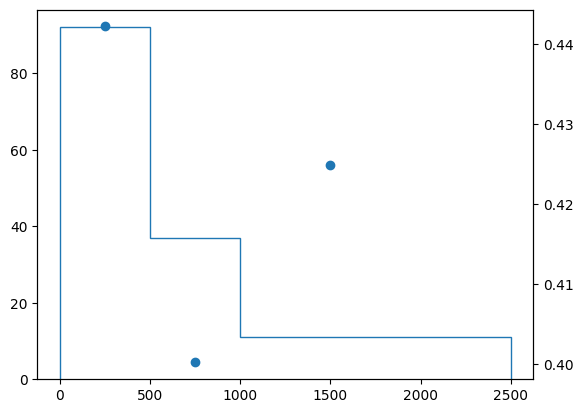

[0.4422297034403999, 0.40017747732532993, 0.4248699375122238]
[0.4337966732234505, 0.3893793527213882, 0.4048779383043852]
[0.4615279689492967, 0.43314062867584385, 0.4545017870875105]


In [76]:
# histogram of the length, and get each interval's average spearman score
from matplotlib import pyplot as plt
import numpy as np
print(max(length_list))
counts, bins = np.histogram(length_list,bins=[0,500,1000,2500])
print(bins)
#plt.stairs(counts, bins)
index = np.digitize(length_list, bins)
print(len(index),len(protssn_list))
#protssn_dic = {}.fromkeys(range(1, len(bins)+1), [])
protssn_dic = {k: [] for k in range(1,len(bins))}
pst_dic = {k: [] for k in range(1,len(bins))}
saprot_dic = {k: [] for k in range(1,len(bins))}
for i,j in enumerate(index):
    protssn_dic[j].append(protssn_list[i])
    pst_dic[j].append(pst_list[i])
    saprot_dic[j].append(saprot_list[i])
    #print(protssn_dic)
protssn_avg = [np.mean(protssn_dic[i]) for i in protssn_dic.keys()]
pst_avg = [np.mean(pst_dic[i]) for i in pst_dic.keys()]
saprot_avg = [np.mean(saprot_dic[i]) for i in saprot_dic.keys()]
# plot each interval's average spearman score on top of the histogram
fig, ax1 = plt.subplots()
plt.stairs(counts, bins)
ax2 = ax1.twinx()

ax2.scatter([250,750,1500],protssn_avg)
plt.show()
print(protssn_avg)
print(pst_avg) 
print(saprot_avg)   

In [78]:
# histogram of the function, and get each function's average spearman score
unique_type = list(set(type_list))
for type in unique_type:
    protssn_list = []
    pst_list = []
    saprot_list = []
    for i in range(len(df)):
        dms_id = df.iloc[i]['DMS_id']
        includes_multiple_mutants = df.iloc[i]['includes_multiple_mutants']
        if (dms_id not in dms_id_ignored) and ~includes_multiple_mutants:
            if df.iloc[i]['coarse_selection_type'] == type:
                df_protssn = pd.read_csv(ProtSSN_result + dms_id + ".csv")
                gt = df_protssn["score"].tolist()
                pred_protssn = df_protssn["ProtSSN_k20_h512"].tolist()
                spearman_score_protssn = spearmanr(gt, pred_protssn)
                protssn_list.append(spearman_score_protssn.correlation)
                df_PST_dms = df_PST[df_PST['protein_id'] == dms_id]
                pred_PST = df_PST_dms["y_score"].tolist()
                gt_PST = df_PST_dms["y_true"].tolist()
                df_saprot = pd.read_csv(SaProt_result + dms_id + "_result.csv")
                pred_saprot = df_saprot["mutant_score"].tolist()
                assert gt == gt_PST
                spearman_score_PST = spearmanr(gt, pred_PST)
                pst_list.append(spearman_score_PST.correlation)
                spearman_score_saprot = spearmanr(gt, pred_saprot)
                saprot_list.append(spearman_score_saprot.correlation)
    print(type, len(protssn_list),np.mean(protssn_list))
    print(type, len(pst_list),np.mean(pst_list))
    print(type, len(saprot_list),np.mean(saprot_list))
    

Expression 17 0.4465868367039278
Expression 17 0.42699449690288005
Expression 17 0.48609295621971593
Stability 15 0.47612057577610273
Stability 15 0.49134156107249893
Stability 15 0.5616114363631621
Activity 37 0.47136967775875227
Activity 37 0.4679551526888465
Activity 37 0.4718056768566821
Binding 8 0.34333112822038175
Binding 8 0.30362870195115615
Binding 8 0.3840404320305888
OrganismalFitness 63 0.4007009004244962
OrganismalFitness 63 0.38726328857244485
OrganismalFitness 63 0.4169747739869776


In [79]:
# spearman by MSA Depth
MSA_depth_list = df["MSA_Neff_L_category"].tolist()
print(MSA_depth_list)
MSA_depth_list = [str(x).lower() for x in MSA_depth_list]
unique_type = list(set(MSA_depth_list))
for type in unique_type:
    protssn_list = []
    pst_list = []
    saprot_list = []
    for i in range(len(df)):
        dms_id = df.iloc[i]['DMS_id']
        includes_multiple_mutants = df.iloc[i]['includes_multiple_mutants']
        if (dms_id not in dms_id_ignored) and ~includes_multiple_mutants:
            if MSA_depth_list[i] == type:
                df_protssn = pd.read_csv(ProtSSN_result + dms_id + ".csv")
                gt = df_protssn["score"].tolist()
                pred_protssn = df_protssn["ProtSSN_k20_h512"].tolist()
                spearman_score_protssn = spearmanr(gt, pred_protssn)
                protssn_list.append(spearman_score_protssn.correlation)
                df_PST_dms = df_PST[df_PST['protein_id'] == dms_id]
                pred_PST = df_PST_dms["y_score"].tolist()
                gt_PST = df_PST_dms["y_true"].tolist()
                df_saprot = pd.read_csv(SaProt_result + dms_id + "_result.csv")
                pred_saprot = df_saprot["mutant_score"].tolist()
                spearman_score_saprot = spearmanr(gt, pred_saprot)
                assert gt == gt_PST
                spearman_score_PST = spearmanr(gt, pred_PST)
                pst_list.append(spearman_score_PST.correlation)
                saprot_list.append(spearman_score_saprot.correlation)
    print(type, len(protssn_list),np.mean(protssn_list))
    print(type, len(pst_list),np.mean(pst_list))
    print(type, len(saprot_list),np.mean(saprot_list))

['medium', 'medium', 'medium', 'High', 'medium', 'medium', 'Low', 'medium', 'high', 'high', 'Medium', 'medium', 'Medium', 'Medium', 'high', 'Medium', 'Medium', 'Low', 'High', 'Medium', 'high', 'high', 'high', 'high', 'low', nan, 'medium', 'high', 'low', 'Low', 'Low', 'Medium', 'High', 'Medium', 'High', 'Medium', 'Medium', 'High', 'high', 'high', 'High', 'Low', 'high', 'high', 'Medium', 'Medium', 'Low', 'low', 'low', 'Medium', 'High', 'High', 'High', 'medium', 'medium', 'medium', 'High', 'High', 'Low', 'high', 'high', 'high', 'High', 'Medium', 'medium', 'low', 'Low', 'low', 'Low', 'medium', 'Medium', 'Medium', 'Medium', 'medium', 'Low', 'Medium', 'medium', 'medium', 'Medium', 'Medium', 'medium', 'high', 'High', 'High', 'Medium', 'Medium', 'medium', 'Medium', 'Medium', 'high', 'medium', 'Medium', 'Medium', 'Medium', 'Medium', 'medium', 'Medium', 'medium', 'medium', 'Low', 'High', 'medium', 'High', 'Low', 'Low', 'low', 'high', 'High', 'High', 'High', 'High', 'High', 'Medium', 'High', 'Hig